<a href="https://colab.research.google.com/github/skywalker0803r/deep-learning-ian-goodfellow/blob/master/LSTNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F 
import requests
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from torch.utils.data import TensorDataset,DataLoader   
import datetime
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
import matplotlib.pyplot as plt

# get model
res =requests.get('https://raw.githubusercontent.com/skywalker0803r/LSTNet.pytorch/master/LSTNet.py').text
exec(res)
model = nn.Sequential(LSTNet(),nn.Sigmoid())

# get data
start,end = datetime.datetime(2016,1,1),datetime.date.today()
df = web.DataReader("AAPL", "yahoo", start, end).drop('Adj Close',axis=1)
df.head()

,High,Low,Open,Close,Volume
Date,,,,,
2016-01-04,26.342501,25.500000,25.652500,26.337500,270597600.0
2016-01-05,26.462500,25.602501,26.437500,25.677500,223164000.0
2016-01-06,25.592501,24.967501,25.139999,25.174999,273829600.0
2016-01-07,25.032499,24.107500,24.670000,24.112499,324377600.0
2016-01-08,24.777500,24.190001,24.637501,24.240000,283192000.0


In [2]:
def make_data_iter(df,ss_x,ss_y,time_step=48):
  data = {'x':[],'y':[]}
  for t in range(len(df)-time_step):
    data['x'].append(ss_x.transform(df.iloc[t:t+time_step,:].values))
    data['y'].append(ss_y.transform(df.iloc[[t+time_step],:][['Close']].values))
  data['x'] = np.array(data['x'])
  data['y'] = np.array(data['y'])
  print(data['x'].shape,data['y'].shape)
  data = TensorDataset(torch.FloatTensor(data['x']),torch.FloatTensor(data['y']))
  data_iter = DataLoader(data,batch_size=64)
  return data_iter

def split_df(df):
  sp1 = int(len(df)*0.8)
  sp2 = int(len(df)*0.9)
  train = df.iloc[:sp1]
  valid = df.iloc[sp1:sp2]
  test = df.iloc[sp2:]
  return train,valid,test

In [3]:
# split data
train,valid,test = split_df(df)
# use train_data make scaler
ss_x = MinMaxScaler().fit(train)
ss_y = MinMaxScaler().fit(train[['Close']])
# apply scaler and make data_iter
train_iter = make_data_iter(train,ss_x,ss_y)
valid_iter = make_data_iter(valid,ss_x,ss_y)
test_iter = make_data_iter(test,ss_x,ss_y)

(939, 48, 5) (939, 1, 1)
(75, 48, 5) (75, 1, 1)
(76, 48, 5) (76, 1, 1)


# test model

In [4]:
for x,y in train_iter:
  y = y.reshape(-1,1)
  print(x.shape,y.shape)
  y_hat = model(x)
  print(y_hat.shape)
  break

torch.Size([64, 48, 5]) torch.Size([64, 1])
torch.Size([64, 1])


# loss and optimizer

In [5]:
loss_fn = lambda a,b:((a-b)**2).mean()
optimizer = Adam(model.parameters(),lr=0.001)

# train_loop

In [6]:
def train_loop(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    best_net = None
    
    for epoch in range(num_epochs):
        # train
        net.train()
        train_loss = 0
        t = 0
        for x,y in train_iter:
            loss = loss_function(net(x),y.reshape(-1,1))
            # weight update
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # record loss
            train_loss += loss.item()
            t += 1
        train_history.append(train_loss/t)
        
        # eval
        net.eval()
        valid_loss = 0
        t = 0
        for x,y in valid_iter:
            loss = loss_function(net(x),y)
            # record loss
            valid_loss += loss.item()
            t += 1
        valid_history.append(valid_loss/t)
        
        # print the epoch loss
        print("epochs {} train loss {:.4f} valid loss {:.4f}".format(
            epoch,train_history[-1],valid_history[-1]))
        
        # record best_net
        if valid_history[-1] <= best_loss:
            best_loss = valid_history[-1]
            best_net = deepcopy(net.eval())
            print('record net')
    
    # when end all epoch plot history
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.title('loss history')
    plt.legend()
    plt.show()
    
    # return best_net
    return best_net

epochs 0 train loss 0.0697 valid loss 0.4145
record net
epochs 1 train loss 0.0680 valid loss 0.4134
record net
epochs 2 train loss 0.0675 valid loss 0.4110
record net
epochs 3 train loss 0.0671 valid loss 0.4083
record net
epochs 4 train loss 0.0668 valid loss 0.4058
record net
epochs 5 train loss 0.0664 valid loss 0.4032
record net
epochs 6 train loss 0.0660 valid loss 0.4007
record net
epochs 7 train loss 0.0656 valid loss 0.3983
record net
epochs 8 train loss 0.0652 valid loss 0.3959
record net
epochs 9 train loss 0.0648 valid loss 0.3935
record net
epochs 10 train loss 0.0644 valid loss 0.3912
record net
epochs 11 train loss 0.0641 valid loss 0.3888
record net
epochs 12 train loss 0.0637 valid loss 0.3866
record net
epochs 13 train loss 0.0633 valid loss 0.3843
record net
epochs 14 train loss 0.0629 valid loss 0.3821
record net
epochs 15 train loss 0.0625 valid loss 0.3798
record net
epochs 16 train loss 0.0622 valid loss 0.3776
record net
epochs 17 train loss 0.0618 valid loss 0.

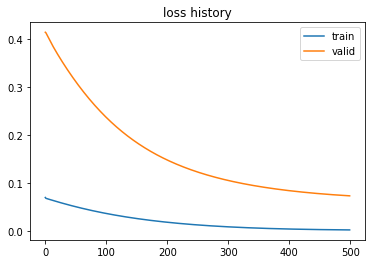

In [7]:
best_model = train_loop(model,train_iter,valid_iter,loss_fn,optimizer,num_epochs=500)

In [14]:
def evaluate(model,data_iter):
  x = data_iter.dataset.tensors[0]
  y = data_iter.dataset.tensors[1]
  y_hat = model(x)
  y_hat = ss_y.inverse_transform(y_hat.detach().numpy().reshape(-1,1))
  y_real = ss_y.inverse_transform(y.detach().numpy().reshape(-1,1))
  plt.plot(y_hat,label='y_hat')
  plt.plot(y_real,label='y_real')
  plt.legend()
  plt.show()

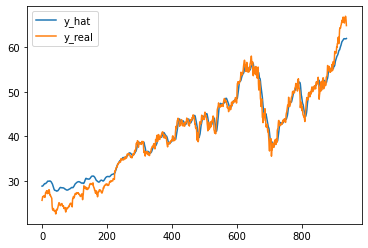

In [15]:
evaluate(best_model,train_iter)

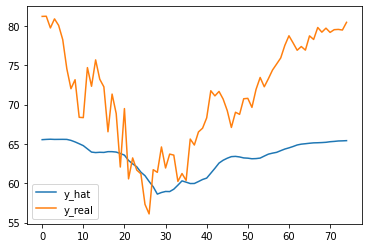

In [16]:
evaluate(best_model,valid_iter)

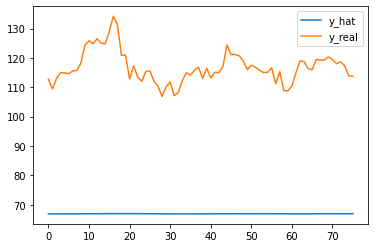

In [17]:
evaluate(best_model,test_iter)